# Homework 4

**Due: 04/02/2020** (Thursday 2nd April at 11:59pm).

## Instructions

+ In any case, develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - you can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope. 

## Student details

+ **First Name:**
+ **Last Name:**
+ **Email:**

## Readings

Before attempting the homework, it is probably a good idea to:
+ Read chapter 1, 2, 4 of [Rasmussen](http://www.gaussianprocess.org/gpml/chapters/);
+ Review the lecture slides and handouts on Gaussian processes (Lec 14-17). 

## Problem 1 


### Part A 

We have seen in the lectures that Gaussian processes define a probability distribution over function spaces. We encode prior information about the underlying function space through the covariance kernel. 
For instance, the squared exponential covariance encode the prior information that the unknown function is an infinitely differentiable (i.e. smooth) function. 
The exponential function, on the other hand, encode the prior knowledge that the unknown function is continuous, but nowhere differentiable. 

Define a kernel to encode the following priors:

1. The unknown function is invariant to the order of its arguments (For instance, if the underlying function is bivariate, i.e. $\mathbf{x} = (x_1, x_2)$, then $f(x_1, x_2) = f(x_2, x_1)$) ? 

2. The unknown function is a "step" function (i.e., the function changes values only at integer inputs)?


#### Solution:
<br><br><br><br><br>

### Part B 

Consider a univariate function $f:\mathbb{R} \rightarrow \mathbb{R}$. $f$ is an unknown function which you know to be twice differentiable. You can query a source of information, say $s$, which returns the function derivative at any arbitrary input, i.e., $s(x) = f'(x)$. 

a. Pose a suitable GP prior on the unknown $f$ - you can assume a zero-mean process. Does this induce a GP prior on $s$? If so, what is it's covariance kernel? 

b. Given a dataset of noisy observations, $\mathcal{D} = \{ x^{(i)}, s^{(i)} + \epsilon^{(i)} \}_{i=1}^{M}$ ($\epsilon^{(i)}$ being i.i.d. zero-mean Gaussian with unknown variance $\sigma_{n}^{2}$), what is the predictive distribution $p(f^*|x^*, \mathcal{D})$ over the unknown function $f$ given a test input $x^*$? 

#### Solution:
<br><br><br><br><br>

## Problem 2 - The Mauna Loa CO$_2$ data set

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start on March 1958 and go all the way to Janurary 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python script below, downloads and plots the data set.

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
try:
  import GPy
except:
  _=!pip install GPy
  import GPy
%matplotlib inline
from sklearn.linear_model import ARDRegression, LinearRegression
np.set_printoptions(suppress=True)
import scipy
import cPickle as pickle
try:
  import wget
except:
  _=!pip install wget
  import wget

In [0]:
# download data
data_url = 'https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/homeworks/mauna_loa_co2.txt'
fname = "mauna_loa_co2.txt"
if not os.path.exists(fname):
    wget.download(data_url, fname)
data = np.loadtxt(fname,dtype=np.float64)

Text(0,0.5,'$y$')

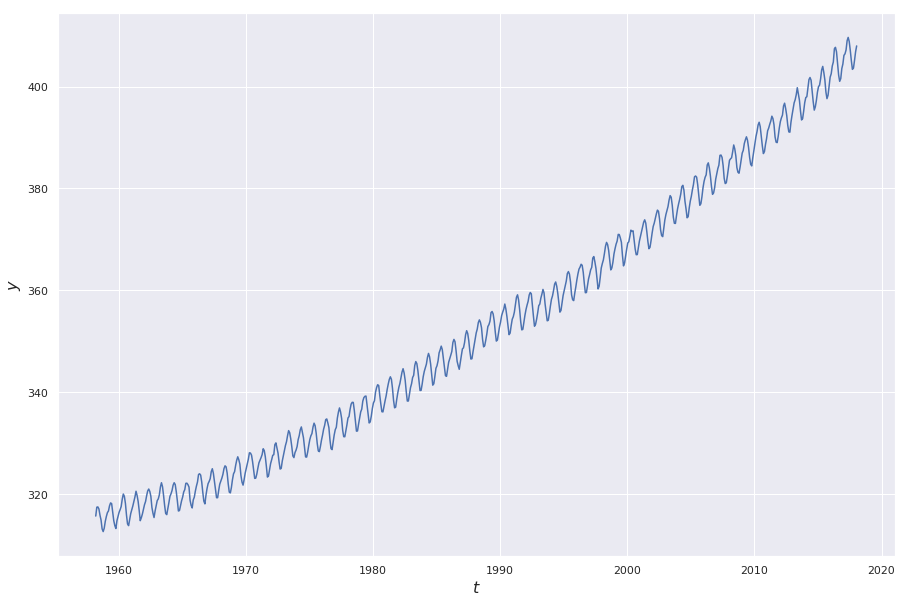

In [64]:
#load data 
t = data[:, 2][:, None]  #time (in decimal dates)
y = data[:, 4][:, None]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, figsize = (15, 10))
ax.plot(t, y)
ax.set_xlabel('$t$', fontsize = 16)
ax.set_ylabel('$y$', fontsize = 16)

In [0]:
# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since the vast majority of the population inhabits the Northen hemisphere, fuel consumption goes up during the Northen winters. Our goal is to study this data set with the regression techniques we learned in class. Specifically we would like to provide an answer to the following task.
+ **Task 1** Predict the evolution of the CO2 levels from Feb 2018 to Feb 2028.
+ **Task 2**  Quantify our uncertainty about this prediction.

### Part  A 

Use any Bayesian linear regression technique discussed in class to construct a map between $t$ and $y$. State clearly which basis functions you use and why. We suggest you use automatic relevance determination (ARD) as implemented in [scikitlearn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html).

The choice of the candidate basis functions is completely up to you. We expect you to justify your choices and interpret your findings. E.g., "I picked these basis functions because I expected this to happen", or "ARD finally selected these basis functions and this can be interpreted as this and that." 

#### Solution

<br><br><br><br>

### Part B

In this problem you have to do exactly the same as in problem 1, but using Gaussian process regression using ``GPy``. 

Select an appropriate kernel function and justify your choice. Note that you can construct new kernels out of existing kernels by taking the sum or product of kernels. For instance, if $k_1$ and $k_2$ are valid covariance kernels, then, $k_{sum} = k_1 + k_2$ and $k_{prod} = k_1 \times k_2$ are also valid covariance kernels. 

#### Solution:

<br><br><br><br><br>

## Problem 3 - Stochastic model for permeability of oil reservoir

In [0]:
class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, Y=None):
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            gpr = GPy.models.GPRegression(X, Y[:, None], k)
            gpr.likelihood.variance = 1e-12
            self.gpr = gpr
            Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            nq = self.Xq.shape[0]
            Xf = np.vstack([self.Xq, x])
            m, C = self.gpr.predict(Xf, full_cov=True)
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:, :].flatten()
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum("i,ji,j,rj->ri", 1. / self.lam, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + np.dot(phi, xi * self.sqrt_lam)

The permeability of the soil is one of the largest unknowns in modeling underground flows. Here, you will create a 2D model of permeability that can be used for propagating uncertainties or as a starting point for model calibration. This is the information that is available to you:
+ You need to build a stochastic model for permeability with as low dimensionality as possible.
+ You need to be able to sample random permeability fields from this model.
+ The permeability is strictly positive.
+ The 2D domain you should consider is $[0, 356]\times[0,670]$ (in meters).
+ Our geologist gave us her best estimate about the permeability field. We have put the results for you in a data file and we show you how to load it and plot it below.
+ When asked how sure she is about the prediction, the geologist gave a standard deviation of about 3.2 on the logarithm of the permeability.
+ She also believes that there are two lengthscales: 50 meters and 10 meters.

Answer the following questions.

### Part A 

Write down the mathematical form of the best stochastic model for the permeability you can come up with using the information above. Are you going to use a GP? Are you going to consider a transformed version of the GP? What would the mean be? What would the covariance function be? What would the parameters of the covariance function be?

#### Solution:

<br><br><br><br><br>

### Part B 

Construct the Karhunen-Loeve expansion of the field using the code provided above. You should: 1) use enough quadrature points so that you get a converged Nystrom approximation; 2) use enough terms to cover $95\%$ of the fields energy; 3) Plot the egenvalues of KLE; 4) Plot the first six eigenfunctions of KLE; 5) Plot six samples of the random field.

Here is the mean field provided by the geologist:

Text(0.5,1,'Mean of the log permeability')

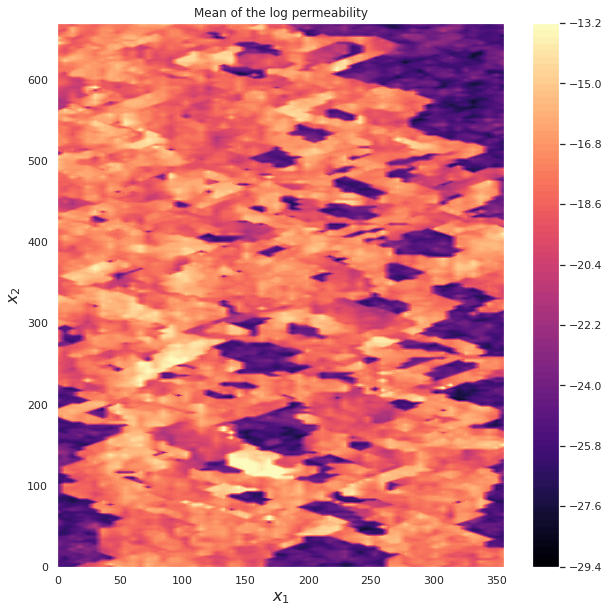

In [87]:
# download the data 
spe10_data_url = 'https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/homeworks/spe10_permx.dat'
spe10_fname = "spe10_permx.dat"
if not os.path.exists(spe10_fname):
    wget.download(spe10_data_url, spe10_fname)
M = np.loadtxt(spe10_fname,dtype=np.float64).T

# visualize the mean field 
x1 = np.linspace(0, 356, 60)
x2 = np.linspace(0, 670, 220)
X1, X2 = np.meshgrid(x1, x2)
fig, ax = plt.subplots(1, figsize = (10, 10))
im=ax.contourf(X1, X2, np.log(M), 100, cmap = 'magma')
fig.colorbar(im, ax=ax)
ax.set_xlabel('$x_1$', fontsize = 16)
ax.set_ylabel('$x_2$', fontsize = 16)
ax.set_title('Mean of the log permeability')

#### Solution:

<br><br><br><br><br>

### Part C

You sent a crew to go and make some measurements of the permeability. Repeate everything you did in b. making use of the new data:
 

|$x_1$ |$x_2$ | $\log K(x_1, x_2)$ |
|------|------|--------------------|
|100.  |200.  | -13.2              |
|300.  |500.  | -25.3              |


#### Solution 
<br><br><br><br><br>